# Twitter Bot or Not?: First Simple Model

Predicting whether or not a Twitter account is a bot or human using account-level information. 
* Target variable: Bot or not? 
    * Bot = 1
    * Human = 0 

**Notes**
* Dataset source: [Twitter Bot Accounts](https://www.kaggle.com/davidmartngutirrez/twitter-bots-accounts?select=twitter_human_bots_dataset.csv)
* Feature notes -- 'friends'?     
    * `friends_count` = Following
    * `followers_count` = Followers

In [2]:
# Basics
import pandas as pd
import psycopg2 as pg
import numpy as np
from collections import Counter

# Visuals
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from visualize import *

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Model support
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, f1_score, 
                             plot_confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve)

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

## Data import and setup

In [3]:
# Postgres info to connect
connection_args = {
    'host': 'localhost',             # Connecting to _local_ version of psql
    'dbname': 'twitter_accounts',    # DB with Twitter info
    'port': 5432                     # port we opened on AWS
}

connection = pg.connect(**connection_args)  

In [4]:
raw_df = pd.read_sql('SELECT * FROM human_bots', connection)

In [2]:
#raw_df = pd.read_csv('data_files/twitter_human_bots_dataset.csv.zip', index_col=False)

In [6]:
# drop funny index column
raw_df.drop(columns=['index'], inplace=True)

# Binary classifications for bots and boolean values
raw_df['bot'] = raw_df['account_type'].apply(lambda x: 1 if x == 'bot' else 0)
raw_df['default_profile'] = raw_df['default_profile'].astype(int)
raw_df['default_profile'] = raw_df['default_profile'].astype(int)
raw_df['default_profile_image'] = raw_df['default_profile_image'].astype(int)
raw_df['geo_enabled'] = raw_df['geo_enabled'].astype(int)
raw_df['verified'] = raw_df['verified'].astype(int)

# datetime conversion
raw_df['created_at'] = pd.to_datetime(raw_df['created_at'])
# hour created
raw_df['hour_created'] = pd.to_datetime(raw_df['created_at']).dt.hour

In [7]:
# usable df setup
df = raw_df[['bot', 'screen_name', 'created_at', 'hour_created', 'verified', 'acct_location', 'geo_enabled', 'lang', 'default_profile', 
              'default_profile_image', 'favourites_count', 'followers_count', 'friends_count', 'statuses_count',
             'average_tweets_per_day', 'account_age_days']]


In [8]:
del raw_df

In [9]:
# Interesting features to look at: 
df['avg_daily_followers'] = np.round(df['followers_count'] / df['account_age_days'])
df['avg_daily_friends'] = np.round(df['followers_count'] / df['account_age_days'])
df['avg_daily_favorites'] = np.round(df['followers_count'] / df['account_age_days'])

# Log transformations for highly skewed data
df['friends_log'] = np.round(np.log(1 + df['friends_count']), 3)
df['followers_log'] = np.round(np.log(1 + df['followers_count']), 3)
df['favs_log'] = np.round(np.log(1 + df['favourites_count']), 3)
df['avg_daily_tweets_log'] = np.round(np.log(1+ df['average_tweets_per_day']), 3)

# Possible popularity metrics
df['popularity'] = np.round(df['friends_log'] * df['followers_log'], 3)
df['tweet_to_followers'] = np.round(np.log( 1+ df['statuses_count']) * np.log(1+ df['followers_count']), 3)

# Log-transformed daily acquisition metrics for dist. plots
df['follower_acq_rate'] = np.round(np.log(1 + (df['followers_count'] / df['account_age_days'])), 3)
df['friends_acq_rate'] = np.round(np.log(1 + (df['friends_count'] / df['account_age_days'])), 3)
df['favs_rate'] = np.round(np.log(1 + (df['friends_count'] / df['account_age_days'])), 3)

<ipython-input-9-f05b6e00d5a8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['avg_daily_followers'] = np.round(df['followers_count'] / df['account_age_days'])
<ipython-input-9-f05b6e00d5a8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['avg_daily_friends'] = np.round(df['followers_count'] / df['account_age_days'])
<ipython-input-9-f05b6e00d5a8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

In [10]:
df.head()

,bot,screen_name,created_at,hour_created,verified,acct_location,geo_enabled,lang,default_profile,default_profile_image,...,avg_daily_favorites,friends_log,followers_log,favs_log,avg_daily_tweets_log,popularity,tweet_to_followers,follower_acq_rate,friends_acq_rate,favs_rate
0,1,best_in_dumbest,2016-10-15 21:32:11,21,0,unknown,0,en,0,0,...,1.0,1.609,7.371,1.609,2.183,11.860,68.625,0.757,0.003,0.003
1,0,CJRubinPhoto,2016-11-09 05:01:30,5,0,Estados Unidos,0,en,0,0,...,1.0,6.781,6.758,6.286,0.168,45.826,37.395,0.485,0.494,0.494
2,0,SVGEGENT,2017-06-17 05:34:27,5,0,"Los Angeles, CA",1,en,0,0,...,0.0,6.389,5.153,8.104,0.623,32.923,35.608,0.138,0.414,0.414
3,0,TinkerVHELPK5,2016-07-21 13:32:25,13,0,"Birmingham, AL",1,en,1,0,...,0.0,6.452,6.250,9.040,0.636,40.325,44.932,0.298,0.354,0.354
4,0,JoleonLescott,2012-01-15 16:32:35,16,1,"England, United Kingdom",1,en,0,0,...,240.0,4.762,13.533,4.489,0.850,64.444,112.911,5.486,0.036,0.036


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37438 entries, 0 to 37437
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   bot                     37438 non-null  int64         
 1   screen_name             37438 non-null  object        
 2   created_at              37438 non-null  datetime64[ns]
 3   hour_created            37438 non-null  int64         
 4   verified                37438 non-null  int64         
 5   acct_location           37438 non-null  object        
 6   geo_enabled             37438 non-null  int64         
 7   lang                    29481 non-null  object        
 8   default_profile         37438 non-null  int64         
 9   default_profile_image   37438 non-null  int64         
 10  favourites_count        37438 non-null  int64         
 11  followers_count         37438 non-null  int64         
 12  friends_count           37438 non-null  int64 

## Unbalanced data? 

In [12]:
num_bots = len(df[df['bot'] == 1])
num_humans = len(df[df['bot'] == 0])

print("Number of bots: ", num_bots)
print("Number of humans: ", num_humans)
print("Bots / Total %: ", (num_bots / len(df)) * 100)

Number of bots:  12425
Number of humans:  25013
Bots / Total %:  33.18820449810353


## Feature selection

In [13]:
df.columns

Index(['bot', 'screen_name', 'created_at', 'hour_created', 'verified',
       'acct_location', 'geo_enabled', 'lang', 'default_profile',
       'default_profile_image', 'favourites_count', 'followers_count',
       'friends_count', 'statuses_count', 'average_tweets_per_day',
       'account_age_days', 'avg_daily_followers', 'avg_daily_friends',
       'avg_daily_favorites', 'friends_log', 'followers_log', 'favs_log',
       'avg_daily_tweets_log', 'popularity', 'tweet_to_followers',
       'follower_acq_rate', 'friends_acq_rate', 'favs_rate'],
      dtype='object')

In [15]:
features = ['verified', 
            #'created_at',
            #'hour_created',
            'geo_enabled', 
            'default_profile', 
            'default_profile_image', 
            'favourites_count', 
            'followers_count', 
            'friends_count', 
            'statuses_count', 
            'average_tweets_per_day',
            #'avg_daily_followers', 
            #'avg_daily_friends',
            #'avg_daily_favorites',
            'popularity', 
            'tweet_to_followers', 
            'follower_acq_rate', 
            'friends_acq_rate', 
            'favs_rate'
           ]

X = df[features]
y = df['bot']

In [17]:
X, X_test, y, y_test = train_test_split(X, y, test_size=.3, random_state=1234)

## Model Selection

### KNN

In [18]:
scalar = StandardScaler()

scalar.fit(X)

X_train_scaled = scalar.transform(X)
X_test_scaled = scalar.transform(X_test)

In [19]:
ks = range(1, 30)

X_train_scaled, X_val_scaled, y_train, y_val = train_test_split(X, y, test_size=.3, random_state=2)

test_errors = np.zeros(len(list(ks)))
acc_scores = np.zeros(len(list(ks)))

for i, k in enumerate(ks):
    
    nn = KNeighborsClassifier(n_neighbors=k)

    nn.fit(X_train_scaled, y_train)
    test_preds = nn.predict(X_val_scaled)
    
    test_errors[i] = np.sqrt(mean_squared_error(y_val, test_preds))
    acc_scores[i] = accuracy_score(y_val, test_preds)
    

optimal_k_r2 = list(ks)[np.argmin(test_errors)]
optimal_error = np.min(test_errors)

optimal_k_acc = list(ks)[np.argmax(acc_scores)]
optimal_acc = np.max(acc_scores)

print("RMSE Metric")
print(f'Optimal number of Neighbors: {optimal_k_r2}\nRoot Mean Squared Error: {optimal_error:.2f}')
print('\nAccuracy Metric')
print(f'Optimal number of Neighbors: {optimal_k_acc}\nAccuracy Score: {optimal_acc:.2f}')    

RMSE Metric
Optimal number of Neighbors: 10
Root Mean Squared Error: 0.40

Accuracy Metric
Optimal number of Neighbors: 10
Accuracy Score: 0.84


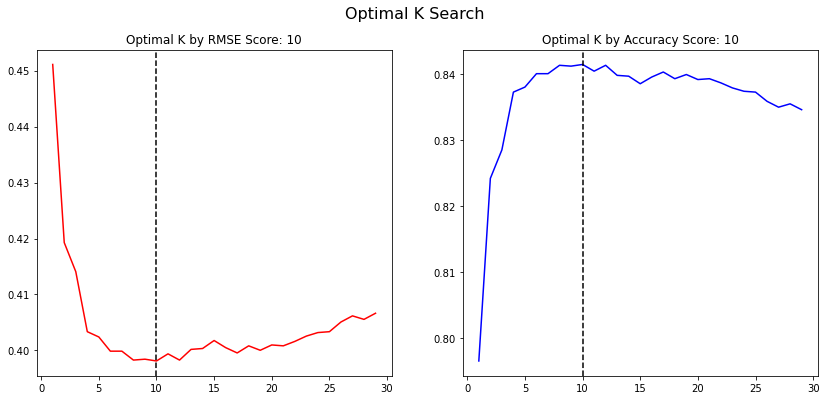

In [20]:
plt.figure(figsize=(14, 6))
plt.suptitle('Optimal K Search', fontsize=16)

# Optimal RMSE
plt.subplot(1, 2, 1)

plt.title('Optimal K by RMSE Score: {}'.format(optimal_k_r2))
plt.plot(list(ks), test_errors, color='red')
plt.axvline(list(ks)[np.argmin(test_errors)], linestyle='--', color='black')

# Optimal accuracy score
plt.subplot(1, 2, 2)

plt.title('Optimal K by Accuracy Score: {}'.format(optimal_k_acc))
plt.plot(list(ks), acc_scores, color='blue')
plt.axvline(list(ks)[np.argmax(acc_scores)], linestyle='--', color='black');

In [21]:
# Resetting train/test split
X, X_test, y, y_test = train_test_split(X, y, test_size=.3, random_state=1234)

# Scaling
scalar = StandardScaler()
scalar.fit(X)
X_train_scaled = scalar.transform(X)
X_test_scaled = scalar.transform(X_test)

In [22]:
knn = KNeighborsClassifier(n_neighbors=10, n_jobs=-1)

cv_scores = cross_val_score(knn, X_train_scaled, y, cv=5)

print("CV Scores: ", cv_scores)
print("Mean Score: ", cv_scores.mean())

CV Scores:  [0.82774598 0.83101663 0.83919324 0.8258381  0.83696838]
Mean Score:  0.8321524648882603


In [25]:
X_train_scaled, X_val_scaled, y_train, y_val = train_test_split(X_train_scaled, y, test_size=.3, random_state=4)

Run a single instance and few classification report: 

In [26]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train_scaled, y_train)
pred = knn.predict(X_val_scaled)

print('Accuracy:  {:.4f}'.format(accuracy_score(y_val, pred)))
print('Precision: {:.4f}'.format(precision_score(y_val, pred)))
print('Recall:    {:.4f}'.format(recall_score(y_val, pred)))
print('F1 Score:  {:.4f}'.format(f1_score(y_val, pred)))

print("")
print(classification_report(y_val, pred))

Accuracy:  0.8270
Precision: 0.7875
Recall:    0.6741
F1 Score:  0.7264

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      3629
           1       0.79      0.67      0.73      1875

    accuracy                           0.83      5504
   macro avg       0.82      0.79      0.80      5504
weighted avg       0.82      0.83      0.82      5504



ROC AUC score =  0.8885567741342886


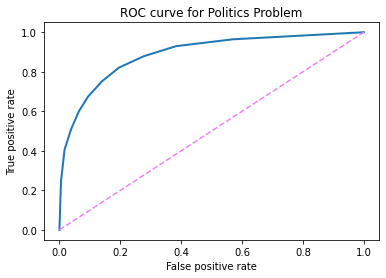

In [27]:
fpr, tpr, thresholds = roc_curve(y_val, knn.predict_proba(X_val_scaled)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Politics Problem');
print("ROC AUC score = ", roc_auc_score(y_val, knn.predict_proba(X_val_scaled)[:,1]))

### Logistic Regression

In [28]:
lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)

pred = lr.predict(X_val_scaled)

print('Accuracy: {:.4f}'.format(accuracy_score(y_val, pred)))
print('Precision: {:.4f}'.format(precision_score(y_val, pred)))
print('Recall: {:.4f}'.format(recall_score(y_val, pred)))
print('F1 Score: {:.4f}'.format(f1_score(y_val, pred)))

print("")
print(classification_report(y_val, pred))

Accuracy: 0.7969
Precision: 0.7006
Recall: 0.7051
F1 Score: 0.7028

              precision    recall  f1-score   support

           0       0.85      0.84      0.85      3629
           1       0.70      0.71      0.70      1875

    accuracy                           0.80      5504
   macro avg       0.77      0.77      0.77      5504
weighted avg       0.80      0.80      0.80      5504



ROC AUC score =  0.8483027463947828


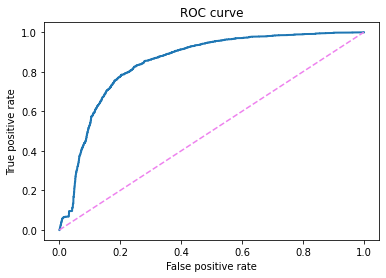

In [29]:
fpr, tpr, thresholds = roc_curve(y_val, lr.predict_proba(X_val_scaled)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_val, lr.predict_proba(X_val_scaled)[:,1]))

### Support Vector Classification

In [30]:
svc = SVC(probability=True)
svc.fit(X_train_scaled, y_train)

pred = svc.predict(X_val_scaled)

print('Accuracy: {:.4f}'.format(accuracy_score(y_val, pred)))
print('Precision: {:.4f}'.format(precision_score(y_val, pred)))
print('Recall: {:.4f}'.format(recall_score(y_val, pred)))
print('F1 Score: {:.4f}'.format(f1_score(y_val, pred)))

print("")
print(classification_report(y_val, pred))

Accuracy: 0.8023
Precision: 0.7005
Recall: 0.7333
F1 Score: 0.7165

              precision    recall  f1-score   support

           0       0.86      0.84      0.85      3629
           1       0.70      0.73      0.72      1875

    accuracy                           0.80      5504
   macro avg       0.78      0.79      0.78      5504
weighted avg       0.80      0.80      0.80      5504



ROC AUC score =  0.847041058142739


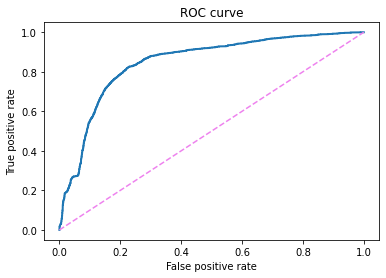

In [31]:
fpr, tpr, thresholds = roc_curve(y_val, svc.predict_proba(X_val_scaled)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_val, svc.predict_proba(X_val_scaled)[:,1]))

In [33]:
# Resetting train/test split for non-scaled models
X, X_test, y, y_test = train_test_split(X, y, test_size=.3, random_state=1234)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.3, random_state=4)

### GaussianNB

In [34]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

pred = gnb.predict(X_val)

print('Accuracy: {:.4f}'.format(accuracy_score(y_val, pred)))
print('Precision: {:.4f}'.format(precision_score(y_val, pred)))
print('Recall: {:.4f}'.format(recall_score(y_val, pred)))
print('F1 Score: {:.4f}'.format(f1_score(y_val, pred)))

print("")
print(classification_report(y_val, pred))

Accuracy: 0.7100
Precision: 0.5369
Recall: 0.9060
F1 Score: 0.6742

              precision    recall  f1-score   support

           0       0.93      0.61      0.74      2576
           1       0.54      0.91      0.67      1276

    accuracy                           0.71      3852
   macro avg       0.73      0.76      0.71      3852
weighted avg       0.80      0.71      0.72      3852



ROC AUC score =  0.8276221061547149


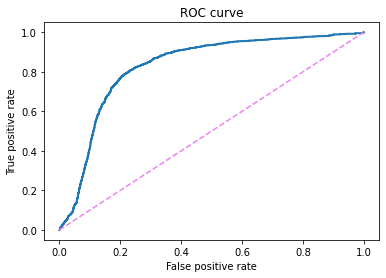

In [35]:
fpr, tpr, thresholds = roc_curve(y_val, gnb.predict_proba(X_val)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_val, gnb.predict_proba(X_val)[:,1]))

### DecisionTree

In [36]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

pred = tree.predict(X_val)

print('Accuracy:  {:.4f}'.format(accuracy_score(y_val, pred)))
print('Precision: {:.4f}'.format(precision_score(y_val, pred)))
print('Recall:    {:.4f}'.format(recall_score(y_val, pred)))
print('F1 Score:  {:.4f}'.format(f1_score(y_val, pred)))

print("")
print(classification_report(y_val, pred))

Accuracy:  0.8113
Precision: 0.7087
Recall:    0.7304
F1 Score:  0.7194

              precision    recall  f1-score   support

           0       0.86      0.85      0.86      2576
           1       0.71      0.73      0.72      1276

    accuracy                           0.81      3852
   macro avg       0.79      0.79      0.79      3852
weighted avg       0.81      0.81      0.81      3852



ROC AUC score =  0.7908636996436847


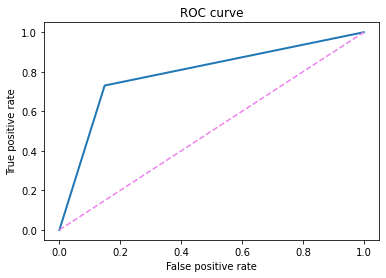

In [37]:
fpr, tpr, thresholds = roc_curve(y_val, tree.predict_proba(X_val)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_val, tree.predict_proba(X_val)[:,1]))

### RandomForest

In [38]:
forest = RandomForestClassifier()
forest.fit(X_train, y_train)

pred = forest.predict(X_val)

print('Accuracy:  {:.4f}'.format(accuracy_score(y_val, pred)))
print('Precision: {:.4f}'.format(precision_score(y_val, pred)))
print('Recall:    {:.4f}'.format(recall_score(y_val, pred)))
print('F1 Score:  {:.4f}'.format(f1_score(y_val, pred)))

print("")
print(classification_report(y_val, pred))

Accuracy:  0.8699
Precision: 0.8396
Recall:    0.7508
F1 Score:  0.7927

              precision    recall  f1-score   support

           0       0.88      0.93      0.91      2576
           1       0.84      0.75      0.79      1276

    accuracy                           0.87      3852
   macro avg       0.86      0.84      0.85      3852
weighted avg       0.87      0.87      0.87      3852



ROC AUC score =  0.9248867347981853


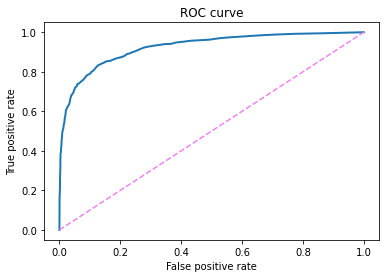

In [39]:
fpr, tpr, thresholds = roc_curve(y_val, forest.predict_proba(X_val)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_val, forest.predict_proba(X_val)[:,1]))

In [41]:
# forest_cm = confusion_matrix(y_val, forest_pred)
# forest_cm

array([[4981,  337],
       [ 636, 1908]])

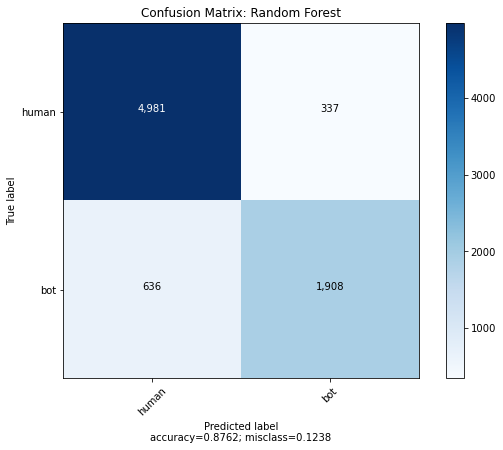

In [42]:
# model = 'Random Forest'

# plot_cm(forest_cm, normalize=False, target_names=['human', 'bot'], title='Confusion Matrix: {}'.format(model))

In [47]:
# forest_bal = RandomForestClassifier(class_weight='balanced')
# forest_bal.fit(X_train, y_train)

# forest_pred = forest_bal.predict(X_val)

In [48]:
# print("Training score: {:.6f}".format(forest_bal.score(X_train, y_train)))
# print("Validation score: {:.6f}".format(forest_bal.score(X_val, y_val)))
# print("")
# print('Accuracy: {:.4f}'.format(accuracy_score(y_val, forest_pred)))
# print('Precision: {:.4f}'.format(precision_score(y_val, forest_pred)))
# print('Recall: {:.4f}'.format(recall_score(y_val, forest_pred)))
# print('F1 Score: {:.4f}'.format(f1_score(y_val, forest_pred)))
# print("")
# print(classification_report(y_val, forest_pred))

Training score: 0.999836
Validation score: 0.876367

Accuracy: 0.8764
Precision: 0.8541
Recall: 0.7453
F1 Score: 0.7960

              precision    recall  f1-score   support

           0       0.89      0.94      0.91      5318
           1       0.85      0.75      0.80      2544

    accuracy                           0.88      7862
   macro avg       0.87      0.84      0.85      7862
weighted avg       0.88      0.88      0.87      7862



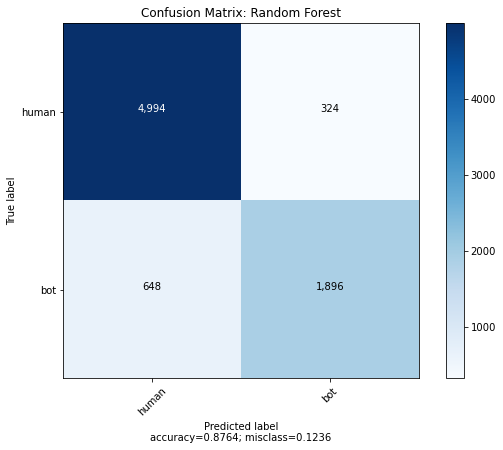

In [49]:
# model = 'Random Forest'

# forest_cm = confusion_matrix(y_val, forest_pred)
# forest_cm

# plot_cm(forest_cm, normalize=False, target_names=['human', 'bot'], 
#         title='Confusion Matrix: {}'.format(model))

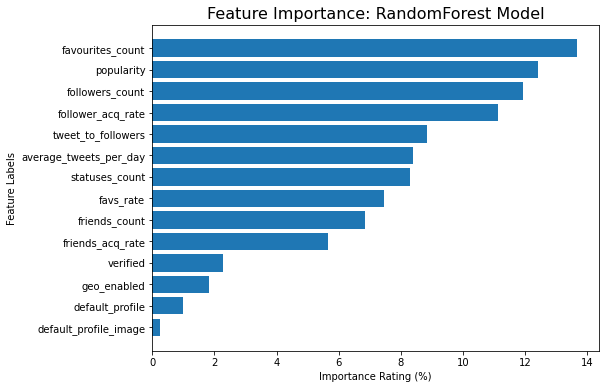

In [69]:
# # set up feature_importance
# importance = forest_bal.feature_importances_
# feature_importance = list(zip(features, importance))

# feature_importance.sort(key = lambda x: x[1])

# # split sorted features_importance into x,y
# feat = [f[0] for f in feature_importance]
# imp = [i[1]*100 for i in feature_importance]

# # Plot feature importance
# plt.figure(figsize=(8, 6))
# plt.title('Feature Importance: RandomForest Model', fontsize=16)
# plt.barh(feat, imp)
# plt.xlabel('Importance Rating (%)')
# plt.ylabel('Feature Labels');

### XGBoost

In [40]:
xgb = XGBClassifier()

xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [42]:
pred = xgb.predict(X_val)

print('Accuracy:  {:.4f}'.format(accuracy_score(y_val, pred)))
print('Precision: {:.4f}'.format(precision_score(y_val, pred)))
print('Recall:    {:.4f}'.format(recall_score(y_val, pred)))
print('F1 Score:  {:.4f}'.format(f1_score(y_val, pred)))

print("")
print(classification_report(y_val, pred))

Accuracy:  0.8686
Precision: 0.8319
Recall:    0.7563
F1 Score:  0.7923

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      2576
           1       0.83      0.76      0.79      1276

    accuracy                           0.87      3852
   macro avg       0.86      0.84      0.85      3852
weighted avg       0.87      0.87      0.87      3852



ROC AUC score =  0.9259717746646158


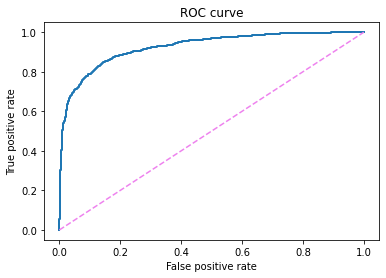

In [43]:
fpr, tpr, thresholds = roc_curve(y_val, xgb.predict_proba(X_val)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_val, xgb.predict_proba(X_val)[:,1]))

**RandomForest** and **XGBoost** seem to perform the best out of the box and will the models I continue to use and tune going forward. 

**Next set of evaluations** 
* Oversampling methods
    * RandomOversampler
    * SMOTE
    * ADASYN
* Undersampling methods
    * Tuning class weight parameters
    * RandomUndersampler

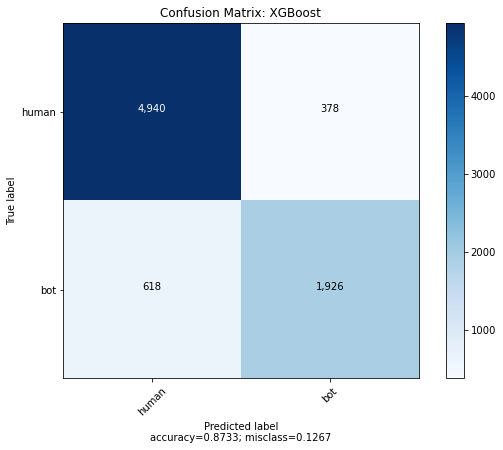

In [75]:
# model = 'XGBoost'

# xgb_cm = confusion_matrix(y_val, xgb_pred)

# plot_cm(xgb_cm, normalize=False, target_names=['human', 'bot'], 
#         title='Confusion Matrix: {}'.format(model))

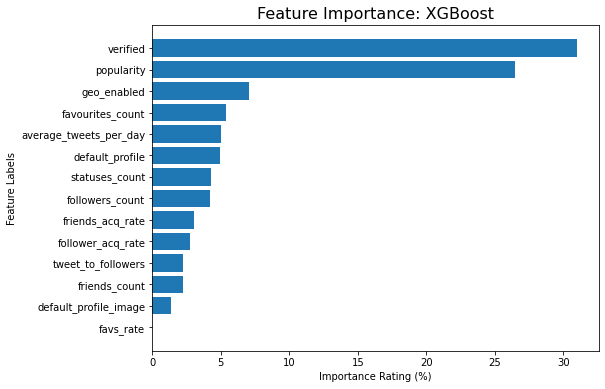

In [77]:
# # set up feature_importance
# importance = xgb.feature_importances_
# feature_importance = list(zip(features, importance))

# feature_importance.sort(key = lambda x: x[1])

# # split sorted features_importance into x,y
# feat = [f[0] for f in feature_importance]
# imp = [i[1]*100 for i in feature_importance]

# # Plot feature importance
# plt.figure(figsize=(8, 6))
# plt.title('Feature Importance: XGBoost', fontsize=16)
# plt.barh(feat, imp)
# plt.xlabel('Importance Rating (%)')
# plt.ylabel('Feature Labels');

## Oversampling Methods

In [78]:
df2 = df.copy()

In [93]:
features = ['verified', 
            #'created_at',
            #'hour_created',
            'geo_enabled', 
            'default_profile', 
            'default_profile_image', 
            'favourites_count', 
            'followers_count', 
            'friends_count', 
            'statuses_count', 
            'average_tweets_per_day',
            #'avg_daily_followers', 
            #'avg_daily_friends',
            #'avg_daily_favorites',
            'popularity', 
            'tweet_to_followers', 
            'follower_acq_rate', 
            'friends_acq_rate', 
            'favs_rate'
           ]

X = df[features]
y = df['bot']

In [94]:
df2.bot.value_counts()

0    25013
1    12425
Name: bot, dtype: int64

In [95]:
X, X_test, y, y_test = train_test_split(X, y, test_size=.3, random_state=1234)

In [123]:
Counter(y), Counter(y_test)

(Counter({0: 17420, 1: 8786}), Counter({0: 7593, 1: 3639}))

In [98]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.3, random_state=1234)

In [100]:
Counter(y_train), Counter(y_val)

(Counter({0: 12195, 1: 6149}), Counter({1: 2637, 0: 5225}))

### RandomOversampler

In [ ]:
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X,y)

In [102]:
Counter(y_resampled)

Counter({0: 12195, 1: 12195})

#### Random Forest

In [109]:
forest = RandomForestClassifier()

forest.fit(X_resampled, y_resampled)

forest_pred = forest.predict(X_val)

In [110]:
print("Training score: {:.6f}".format(forest.score(X_resampled, y_resampled)))
print("Validation score: {:.6f}".format(forest.score(X_val, y_val)))
print("")
print('Accuracy: {:.4f}'.format(accuracy_score(y_val, forest_pred)))
print('Precision: {:.4f}'.format(precision_score(y_val, forest_pred)))
print('Recall: {:.4f}'.format(recall_score(y_val, forest_pred)))
print('F1 Score: {:.4f}'.format(f1_score(y_val, forest_pred)))
print("")
print(classification_report(y_val, forest_pred))

Training score: 0.999877
Validation score: 0.866701

Accuracy: 0.8667
Precision: 0.8218
Recall: 0.7694
F1 Score: 0.7948

              precision    recall  f1-score   support

           0       0.89      0.92      0.90      5225
           1       0.82      0.77      0.79      2637

    accuracy                           0.87      7862
   macro avg       0.85      0.84      0.85      7862
weighted avg       0.87      0.87      0.87      7862



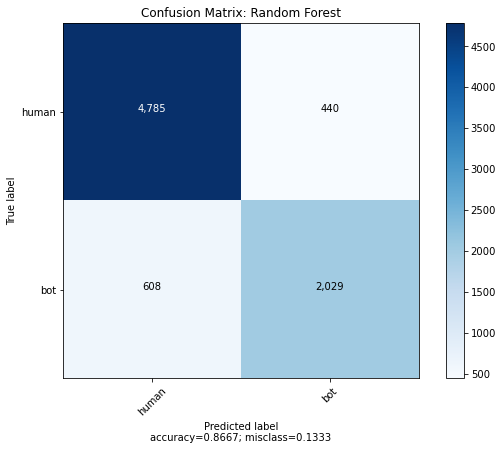

In [111]:
model = 'Random Forest'

forest_cm = confusion_matrix(y_val, forest_pred)
forest_cm

plot_cm(forest_cm, normalize=False, target_names=['human', 'bot'], 
        title='Confusion Matrix: {}'.format(model))

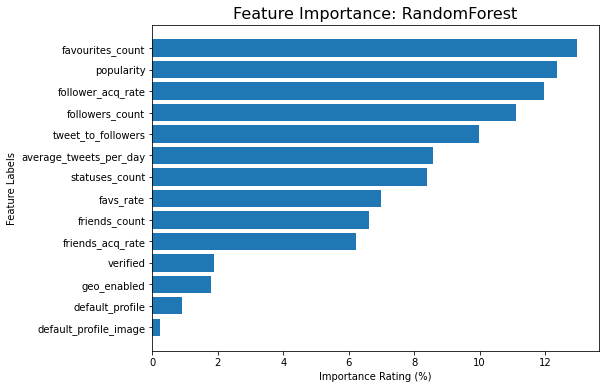

In [116]:
# set up feature_importance
importance = forest.feature_importances_
feature_importance = list(zip(features, importance))

feature_importance.sort(key = lambda x: x[1])

# split sorted features_importance into x,y
feat = [f[0] for f in feature_importance]
imp = [i[1]*100 for i in feature_importance]

# Plot feature importance
plt.figure(figsize=(8, 6))
plt.title('Feature Importance: RandomForest', fontsize=16)
plt.barh(feat, imp)
plt.xlabel('Importance Rating (%)')
plt.ylabel('Feature Labels');

#### XGBoost

In [112]:
xgb = XGBClassifier()

xgb.fit(X_resampled, y_resampled)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [113]:
xgb_pred = xgb.predict(X_val)

print("Training score: {:.6f}".format(xgb.score(X_resampled, y_resampled)))
print("Validation score: {:.6f}".format(xgb.score(X_val, y_val)))
print("")
print('Accuracy: {:.4f}'.format(accuracy_score(y_val, xgb_pred)))
print('Precision: {:.4f}'.format(precision_score(y_val, xgb_pred)))
print('Recall: {:.4f}'.format(recall_score(y_val, xgb_pred)))
print('F1 Score: {:.4f}'.format(f1_score(y_val, xgb_pred)))
print("")
print(classification_report(y_val, xgb_pred))

Training score: 0.951087
Validation score: 0.862885

Accuracy: 0.8629
Precision: 0.8004
Recall: 0.7876
F1 Score: 0.7940

              precision    recall  f1-score   support

           0       0.89      0.90      0.90      5225
           1       0.80      0.79      0.79      2637

    accuracy                           0.86      7862
   macro avg       0.85      0.84      0.85      7862
weighted avg       0.86      0.86      0.86      7862



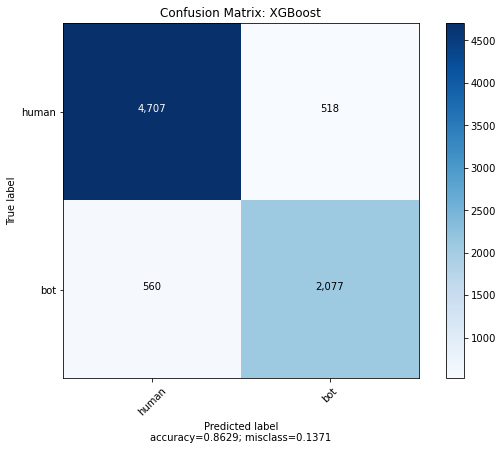

In [131]:
model = 'XGBoost'

xgb_cm = confusion_matrix(y_val, xgb_pred)

plot_cm(xgb_cm, normalize=False, target_names=['human', 'bot'], 
        title='Confusion Matrix: {}'.format(model))

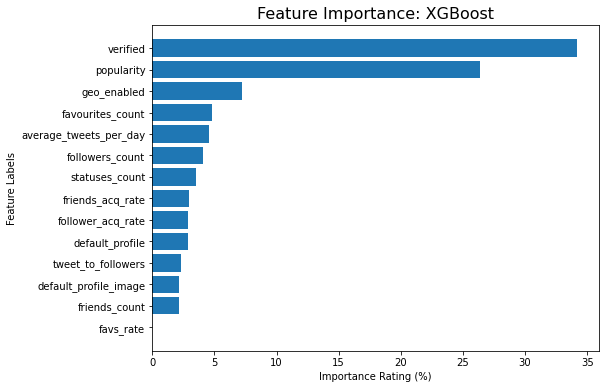

In [115]:
# set up feature_importance
importance = xgb.feature_importances_
feature_importance = list(zip(features, importance))

feature_importance.sort(key = lambda x: x[1])

# split sorted features_importance into x,y
feat = [f[0] for f in feature_importance]
imp = [i[1]*100 for i in feature_importance]

# Plot feature importance
plt.figure(figsize=(8, 6))
plt.title('Feature Importance: XGBoost', fontsize=16)
plt.barh(feat, imp)
plt.xlabel('Importance Rating (%)')
plt.ylabel('Feature Labels');

### SMOTE

In [126]:
# SMOTE
X_smoted, y_smoted = SMOTE(random_state=42).fit_sample(X_train,y_train)

In [127]:
Counter(y_smoted)

Counter({0: 12195, 1: 12195})

#### Random Forest

In [128]:
forest = RandomForestClassifier()

forest.fit(X_smoted, y_smoted)

forest_pred = forest.predict(X_val)

In [129]:
print("Training score: {:.6f}".format(forest.score(X_smoted, y_smoted)))
print("Validation score: {:.6f}".format(forest.score(X_val, y_val)))
print("")
print('Accuracy: {:.4f}'.format(accuracy_score(y_val, forest_pred)))
print('Precision: {:.4f}'.format(precision_score(y_val, forest_pred)))
print('Recall: {:.4f}'.format(recall_score(y_val, forest_pred)))
print('F1 Score: {:.4f}'.format(f1_score(y_val, forest_pred)))
print("")
print(classification_report(y_val, forest_pred))

Training score: 0.999918
Validation score: 0.859705

Accuracy: 0.8597
Precision: 0.7919
Recall: 0.7892
F1 Score: 0.7905

              precision    recall  f1-score   support

           0       0.89      0.90      0.89      5225
           1       0.79      0.79      0.79      2637

    accuracy                           0.86      7862
   macro avg       0.84      0.84      0.84      7862
weighted avg       0.86      0.86      0.86      7862



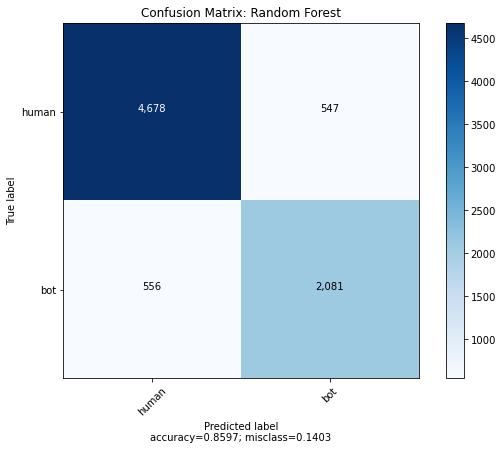

In [130]:
model = 'Random Forest'

forest_cm = confusion_matrix(y_val, forest_pred)
forest_cm

plot_cm(forest_cm, normalize=False, target_names=['human', 'bot'], 
        title='Confusion Matrix: {}'.format(model))

#### XGBoost

In [142]:
xgb = XGBClassifier()

xgb.fit(X_smoted, y_smoted)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [143]:
xgb_pred = xgb.predict(X_val)

print("Training score: {:.6f}".format(xgb.score(X_smoted, y_smoted)))
print("Validation score: {:.6f}".format(xgb.score(X_val, y_val)))
print("")
print('Accuracy: {:.4f}'.format(accuracy_score(y_val, xgb_pred)))
print('Precision: {:.4f}'.format(precision_score(y_val, xgb_pred)))
print('Recall: {:.4f}'.format(recall_score(y_val, xgb_pred)))
print('F1 Score: {:.4f}'.format(f1_score(y_val, xgb_pred)))
print("")
print(classification_report(y_val, xgb_pred))

Training score: 0.948380
Validation score: 0.860850

Accuracy: 0.8608
Precision: 0.7880
Recall: 0.8005
F1 Score: 0.7942

              precision    recall  f1-score   support

           0       0.90      0.89      0.89      5225
           1       0.79      0.80      0.79      2637

    accuracy                           0.86      7862
   macro avg       0.84      0.85      0.84      7862
weighted avg       0.86      0.86      0.86      7862



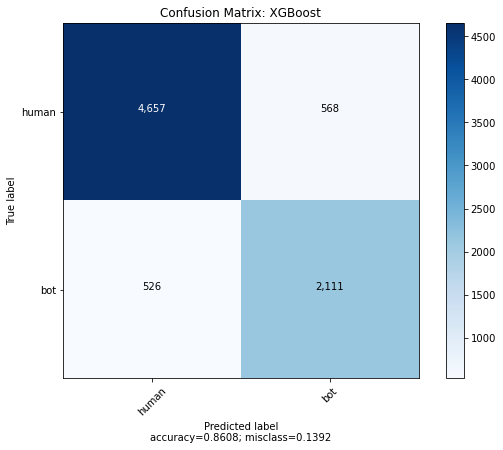

In [144]:
model = 'XGBoost'

xgb_cm = confusion_matrix(y_val, xgb_pred)

plot_cm(xgb_cm, normalize=False, target_names=['human', 'bot'], 
        title='Confusion Matrix: {}'.format(model))

### ADASYN

In [134]:
X_adasyn, y_adasyn = ADASYN(random_state=42).fit_sample(X_train, y_train)

In [135]:
Counter(y_adasyn)

Counter({0: 12195, 1: 12248})

#### RandomForest

In [136]:
forest = RandomForestClassifier()

forest.fit(X_adasyn, y_adasyn)

forest_pred = forest.predict(X_val)

In [137]:
print("Training score: {:.6f}".format(forest.score(X_adasyn, y_adasyn)))
print("Validation score: {:.6f}".format(forest.score(X_val, y_val)))
print("")
print('Accuracy: {:.4f}'.format(accuracy_score(y_val, forest_pred)))
print('Precision: {:.4f}'.format(precision_score(y_val, forest_pred)))
print('Recall: {:.4f}'.format(recall_score(y_val, forest_pred)))
print('F1 Score: {:.4f}'.format(f1_score(y_val, forest_pred)))
print("")
print(classification_report(y_val, forest_pred))

Training score: 0.999918
Validation score: 0.846095

Accuracy: 0.8461
Precision: 0.7468
Recall: 0.8187
F1 Score: 0.7811

              precision    recall  f1-score   support

           0       0.90      0.86      0.88      5225
           1       0.75      0.82      0.78      2637

    accuracy                           0.85      7862
   macro avg       0.83      0.84      0.83      7862
weighted avg       0.85      0.85      0.85      7862



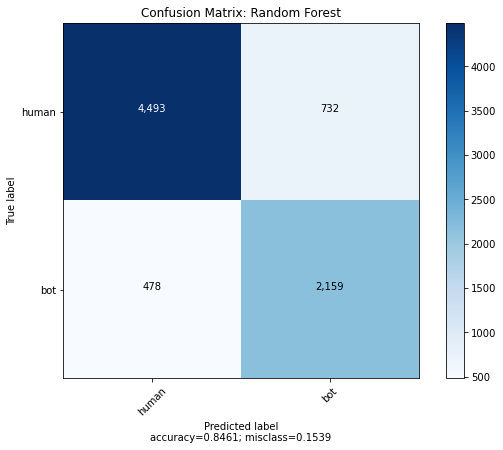

In [138]:
model = 'Random Forest'

forest_cm = confusion_matrix(y_val, forest_pred)
forest_cm

plot_cm(forest_cm, normalize=False, target_names=['human', 'bot'], 
        title='Confusion Matrix: {}'.format(model))

#### XGBoost

In [139]:
xgb = XGBClassifier()

xgb.fit(X_adasyn, y_adasyn)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [140]:
xgb_pred = xgb.predict(X_val)

print("Training score: {:.6f}".format(xgb.score(X_adasyn, y_adasyn)))
print("Validation score: {:.6f}".format(xgb.score(X_val, y_val)))
print("")
print('Accuracy: {:.4f}'.format(accuracy_score(y_val, xgb_pred)))
print('Precision: {:.4f}'.format(precision_score(y_val, xgb_pred)))
print('Recall: {:.4f}'.format(recall_score(y_val, xgb_pred)))
print('F1 Score: {:.4f}'.format(f1_score(y_val, xgb_pred)))
print("")
print(classification_report(y_val, xgb_pred))

Training score: 0.937201
Validation score: 0.846350

Accuracy: 0.8463
Precision: 0.7468
Recall: 0.8199
F1 Score: 0.7816

              precision    recall  f1-score   support

           0       0.90      0.86      0.88      5225
           1       0.75      0.82      0.78      2637

    accuracy                           0.85      7862
   macro avg       0.83      0.84      0.83      7862
weighted avg       0.85      0.85      0.85      7862



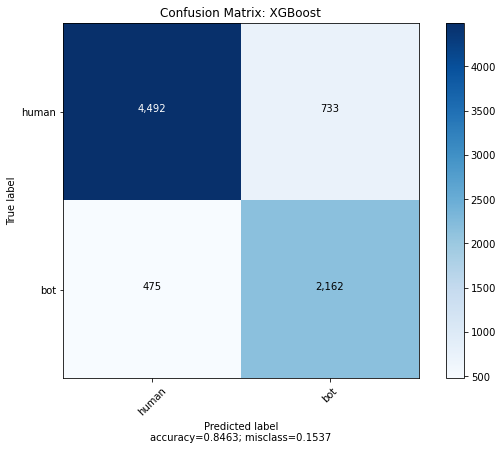

In [141]:
model = 'XGBoost'

xgb_cm = confusion_matrix(y_val, xgb_pred)

plot_cm(xgb_cm, normalize=False, target_names=['human', 'bot'], 
        title='Confusion Matrix: {}'.format(model))